# Software profesional en Acústica 2024-25 (M2i)

*This notebook contains a modification of the notebook [FEM_Helmholtz_equation](https://github.com/spatialaudio/computational_acoustics/blob/master/FEM_Helmholtz_equation.ipynb), created by Sascha Spors, Frank Schultz, Computational Acoustics Examples, 2018. The text/images are licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/). The code is released under the [MIT license](https://opensource.org/licenses/MIT).*

First, we need to install on the fly FEniCS 2019.1.0 using the [FEM on Colab](https://fem-on-colab.github.io/packages.html) install script:

In [1]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"

# Revisiting the numerical solution of the Helmholtz equation: FEM and planewaves

This notebook illustrates the numerical solution of the wave equation for harmonic excitation using the so called [Finite Element Method](https://en.wikipedia.org/wiki/Finite_element_method) (FEM). The method aims at an approximate solution by subdividing the area of interest into smaller parts with simpler geometry, linking these parts together and applying methods from the calculus of variations to solve the problem numerically. The FEM is a well established method for the numerical approximation of the solution of partial differential equations (PDEs). The solutions of PDEs are often known analytically only for rather simple geometries. FEM based simulations allow to gain insights into other more complex cases.

## Problem Statement

The inhomogeneous linear [wave equation](https://en.wikipedia.org/wiki/Wave_equation) is given as

\begin{equation*}
\Delta p(\boldsymbol{x}, t) - \frac{1}{c^2} \frac{\partial^2}{\partial t^2} p(\boldsymbol{x}, t) = - f(\boldsymbol{x}, t) ,
\end{equation*}

where $p(\boldsymbol{x}, t)$ denotes the sound pressure at position $\boldsymbol{x}$, $c$ the speed of sound and $f(\boldsymbol{x}, t)$ the inhomogeneity.
For an harmonic excitation $f(\boldsymbol{x}, t) = \Re \{ F(\boldsymbol{x}, \omega) \mathrm{e}^{\mathrm{j} \omega t} \}$ with frequency $\omega = 2 \pi f$ we choose the Ansatz $p(\boldsymbol{x}, t) = \Re \{ P(\boldsymbol{x}, \omega) \mathrm{e}^{\mathrm{j} \omega t} \}$ for the sound pressure.
Introduction of the complex quantities into the wave equation yields

\begin{equation*}
\Delta P(\boldsymbol{x}, \omega) \mathrm{e}^{\mathrm{j} \omega t} + \frac{\omega^2}{c^2} P(\boldsymbol{x}, \omega) \mathrm{e}^{\mathrm{j} \omega t} = - F(\boldsymbol{x}, \omega) \mathrm{e}^{\mathrm{j} \omega t} ,
\end{equation*}

and canceling out the $\mathrm{e}^{\mathrm{j} \omega t}$ terms yields the [Helmholtz equation](https://en.wikipedia.org/wiki/Helmholtz_equation)

\begin{equation*}
\Delta P(\boldsymbol{x}, \omega) + \frac{\omega^2}{c^2} P(\boldsymbol{x}, \omega) = - F(\boldsymbol{x}, \omega) .
\end{equation*}

We aim for a numerical solution of the Helmholtz equation on the domain $\Omega$ with respect to the homogeneous Dirichlet boundary condition

\begin{equation*}
P(\boldsymbol{x}, \omega) = P_{D} \qquad \text{for } \boldsymbol{x} \in \partial \Omega
\end{equation*}

where $P_{D}$ is the Dirichlet data.

## Variational Formulation

The FEM is based on expressing the partial differential equation (PDE) to be solved in its [variational](https://en.wikipedia.org/wiki/Calculus_of_variations) or weak form.
The first step towards this formulation is to multiply the Helmholtz equation by the test function $Q(\boldsymbol{x}, \omega)$

\begin{equation*}
\Delta P(\boldsymbol{x}, \omega)Q(\boldsymbol{x}, \omega)  + \frac{\omega^2}{c^2} P(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) = - F(\boldsymbol{x}, \omega)  Q(\boldsymbol{x}, \omega) ,
\end{equation*}

followed by integration over the domain $V$

\begin{equation*}
\int_\Omega \Delta P(\boldsymbol{x}, \omega)  Q(\boldsymbol{x}, \omega) \mathrm{d}x  + \frac{\omega^2}{c^2} \int_\Omega P(\boldsymbol{x}, \omega)  Q(\boldsymbol{x}, \omega) \mathrm{d}x = - \int_\Omega F(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) \mathrm{d}x ,
\end{equation*}

where $\mathrm{d}x$ denotes a suitably chosen differential element for integration.
Application of [Green's first identity](https://en.wikipedia.org/wiki/Green%27s_identities) yields

\begin{equation*}
{-} \int_\Omega \nabla P(\boldsymbol{x}, \omega) \cdot \nabla Q(\boldsymbol{x}, \omega) \mathrm{d}x  + \int_{\partial \Omega} Q(\boldsymbol{x}, \omega) \frac{\partial}{\partial n}  P(\boldsymbol{x}, \omega) \mathrm{d}s + \frac{\omega^2}{c^2} \int_\Omega P(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) \mathrm{d}x = - \int_\Omega F(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) \mathrm{d}x .
\end{equation*}

This way the differential order of the first integral is lowered which is advisable for application of the FEM.
The second integral vanishes as 

* the variation formulation requires $Q(\boldsymbol{x}, \omega) = 0$ on $\partial \Omega$ where $P(\boldsymbol{x}, \omega)$ is known - here by the pure Dirichlet boundary condition 

This results in the variational/weak formulation of the Helmholtz equation

\begin{equation*}
{-} \int_\Omega \nabla P(\boldsymbol{x}, \omega) \cdot \nabla Q(\boldsymbol{x}, \omega) \mathrm{d}x  + \frac{\omega^2}{c^2} \int_\Omega P(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) \mathrm{d}x = - \int_\Omega F(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) \mathrm{d}x .
\end{equation*}

It is common to express the integral equation above in terms of the bilinear $a(P, Q)$ and linear $L(Q)$ forms 

\begin{equation*}
a(P, Q) = \frac{\omega^2}{c^2} \int_\Omega P(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) \mathrm{d}x - \int_\Omega \nabla P(\boldsymbol{x}, \omega) \cdot \nabla Q(\boldsymbol{x}, \omega) \mathrm{d}x ,
\end{equation*}

\begin{equation*}
L(Q) = - \int_\Omega F(\boldsymbol{x}, \omega) Q(\boldsymbol{x}, \omega) \mathrm{d}x ,
\end{equation*}

where

\begin{equation*}
a(P, Q) = L(Q)\qquad \forall Q .
\end{equation*}

## Numerical Solution

The numerical solution of the variational problem is based on [FEniCS](https://fenicsproject.org/), an open-source framework for numerical solution of PDEs.
Its high-level Python interface `dolfin` is used in the following to define the problem and compute its solution.
The implementation is based on the variational formulation derived above.
It is common in the FEM to denote the solution of the problem by $u$ and the test function by $v$.
The definition of the problem in FEniCS is very close to the mathematical formulation of the problem.
We limit ourselves to real-valued $P(\boldsymbol{x}, \omega)$ due to the assumption of Dirichlet real data.

A function is defined for this purpose, accompanied by a plotting routine for the resulting sound field.

In [6]:
import numpy as np
import dolfin
import mshr
import matplotlib.pyplot as plt

# Compute the Finite Element approximation
def FEM_Helmholtz(mesh, frequency, dirichlet_data, c=343):
    '''numerical solution of the Helmholtz equation using the FEM'''
    
    # squared wavenumber
    k2 = dolfin.Constant(2*dolfin.pi*frequency/c)**2
    
    # define function space
    V = dolfin.FunctionSpace(mesh, "CG", 2)

    # define boundary conditions
    bcs = dolfin.DirichletBC(V, dirichlet_data, "on_boundary")
    
    # define variational problem
    u = dolfin.TrialFunction(V)
    v = dolfin.TestFunction(V)

    a = k2 * dolfin.inner(u, v) * dolfin.dx - dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v)) * dolfin.dx
    L = dolfin.Constant(0) * v * dolfin.dx
    
    # Assemble the linear system of equations
    A, b = dolfin.assemble_system(a, L, bcs)

    # compute solution
    u = dolfin.Function(V)
    dolfin.solve(A, u.vector(), b)

    return u, V

# Compute the Finite Element error
def compute_error(u, uex, V):
    uex_interp = dolfin.interpolate(uex, V)
    return dolfin.errornorm(uex_interp, u)/dolfin.norm(uex_interp)


# Plot the Finite Element approximation
def plot_soundfield(u):
    '''plot solution of FEM-based simulation'''
    fig = plt.figure(figsize=(10,10))
    fig = dolfin.plot(u)
    plt.title(r'$P(\mathbf{x}, \omega)$')
    plt.xlabel(r'$x$ / m')
    plt.ylabel(r'$y$ / m')
    plt.colorbar(fig, fraction=0.038, pad=0.04);

### Sound Field in a Rectangular Room with Sound-soft Boundaries

The two-dimensional sound field in a rectangular room whose height is very small compared to the wavelength and with soft boundaries (Dirichlet boundary condition) is computed for the frequency $f=120$ Hz. The Dirichlet data is settled in such a manner that the exact solution is the real part of a plane wave
$$
P_{ex}(\boldsymbol{x}, \omega)=\cos(k_{0}x_0+k_{1}x_{1}),\qquad (k_0,k_1)=\frac{\omega}{c}(\cos\theta,\sin\theta),\qquad \theta=\frac{\pi}{4}.
$$

L2-relative error: 3.1335849604778276e-07


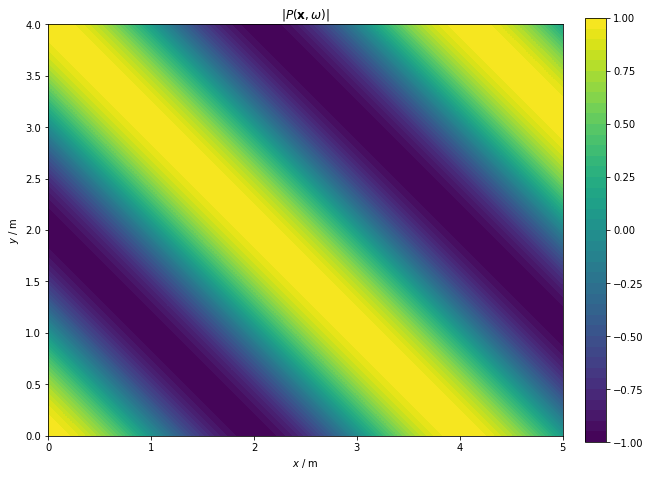

In [5]:
# define geometry and mesh
mesh = dolfin.RectangleMesh(dolfin.Point(0,0), dolfin.Point(5,4), 200, 200, "right/left")

# Physical data
freq = 120.
c = 343.

# Exact solution: plane wave with wavenumber vector (k0,k1)
theta = np.pi/4
k0 = 2*np.pi*freq/c*np.cos(theta)
k1 = 2*np.pi*freq/c*np.sin(theta)
uex = dolfin.Expression("cos(k0*x[0]+k1*x[1])", k0=k0, k1=k1, degree=5)

# compute solution
u, V = FEM_Helmholtz(mesh, freq, uex, c)

# compute error
print('L2-relative error:', compute_error(u, uex, V))

# plot sound field
plot_soundfield(u)
plt.title(r'$|P(\mathbf{x}, \omega)|$');

### Study of convergence

Let's check the order of convergence of this finite element discretization computing the error for sucesive refinements of the mesh

In [7]:
# Mesh 50,50
mesh = dolfin.RectangleMesh(dolfin.Point(0,0), dolfin.Point(5,4), 50, 50, "right/left")
u, V = FEM_Helmholtz(mesh, freq, uex, c)
print('Mesh size', mesh.hmax())
print('L2-relative error:', compute_error(u, uex, V))
# Mesh 50,50
mesh = dolfin.RectangleMesh(dolfin.Point(0,0), dolfin.Point(5,4), 100, 100, "right/left")
u, V = FEM_Helmholtz(mesh, freq, uex, c)
print('Mesh size', mesh.hmax())
print('L2-relative error:', compute_error(u, uex, V))
# Mesh 50,50
mesh = dolfin.RectangleMesh(dolfin.Point(0,0), dolfin.Point(5,4), 200, 200, "right/left")
u, V = FEM_Helmholtz(mesh, freq, uex, c)
print('Mesh size', mesh.hmax())
print('L2-relative error:', compute_error(u, uex, V))

Mesh size 0.12806248474865742
L2-relative error: 2.3773320820502896e-05
Mesh size 0.06403124237432907
L2-relative error: 2.6066554618907065e-06
Mesh size 0.032015621187164535
L2-relative error: 3.1335849604778276e-07


**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).